In [1]:
"""
This tutorial shows how to generate some simple adversarial examples
and train a model using adversarial training using nothing but pure
TensorFlow.
It is very similar to mnist_tutorial_keras_tf.py, which does the same
thing but with a dependence on keras.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import tensorflow as tf
from tensorflow.python.platform import app
from tensorflow.python.platform import flags
import logging

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval
from cleverhans.attacks import FastGradientMethod
from tutorials.tutorial_models import make_basic_cnn
from cleverhans.utils import AccuracyReport, set_log_level

import os
import os.path as osp

In [2]:
"""
MNIST cleverhans tutorial
:param train_start: index of first training set example
:param train_end: index of last training set example
:param test_start: index of first test set example
:param test_end: index of last test set example
:param nb_epochs: number of epochs to train model
:param batch_size: size of training batches
:param learning_rate: learning rate for training
:param testing: if true, complete an AccuracyReport for unit tests
  to verify that performance is adequate
:param clean_train: if true, train on clean examples
"""

train_start=0
train_end=60000
test_start=0
test_end=10000

# Training parameters
nb_epochs=2 # 6
batch_size=128
learning_rate=0.001

In [3]:
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# Set logging level to see debug information
set_log_level(logging.DEBUG)

# Create TF session
sess = tf.Session()

# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end)

# Use label smoothing (don't be too confident)
assert Y_train.shape[1] == 10
label_smooth = .1
Y_train = Y_train.clip(label_smooth / 9., 1. - label_smooth)

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

model_path = "models/mnist"

# Train an MNIST model
train_params = {
    'nb_epochs': nb_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate
}

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


## Train our basic MNIST model

In [4]:
model = make_basic_cnn()
preds = model.get_probs(x)

def evaluate():
    # Evaluate the accuracy of the MNIST model on legitimate test
    # examples
    eval_params = {'batch_size': batch_size}
    acc = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
    report.clean_train_clean_eval = acc
    assert X_test.shape[0] == test_end - test_start, X_test.shape
    print('Test accuracy on legitimate examples: %0.4f' % acc)
model_train(sess, x, y, preds, X_train, Y_train, evaluate=evaluate,
            args=train_params)

# # Calculate training error
# eval_params = {'batch_size': batch_size}
# acc = model_eval(sess, x, y, preds, X_train, Y_train, args=eval_params)
# report.train_clean_train_clean_eval = acc

# Initialize the Fast Gradient Sign Method (FGSM) attack object and
# graph
fgsm = FastGradientMethod(model, sess=sess)

adv_x = fgsm.generate(x, eps=0.3)
preds_adv = model.get_probs(adv_x)

# Evaluate the accuracy of the MNIST model on adversarial examples
eval_par = {'batch_size': batch_size}
acc = model_eval(sess, x, y, preds_adv, X_test, Y_test, args=eval_par)
print('Test accuracy on adversarial examples: %0.4f\n' % acc)
report.clean_train_adv_eval = acc

# # Calculate training error
# eval_par = {'batch_size': batch_size}
# acc = model_eval(sess, x, y, preds_adv, X_train,
#                  Y_train, args=eval_par)
# report.train_clean_train_adv_eval = acc
    
print("Completed training of model on clean data")

[INFO 2017-08-18 19:11:31,288 cleverhans] Epoch 0 took 5.847287654876709 seconds


Test accuracy on legitimate examples: 0.9871


[INFO 2017-08-18 19:11:36,752 cleverhans] Epoch 1 took 5.19570779800415 seconds


Test accuracy on legitimate examples: 0.9903


[INFO 2017-08-18 19:11:42,231 cleverhans] Epoch 2 took 5.212144374847412 seconds


Test accuracy on legitimate examples: 0.9913


[INFO 2017-08-18 19:11:47,728 cleverhans] Epoch 3 took 5.231789588928223 seconds


Test accuracy on legitimate examples: 0.9917


[INFO 2017-08-18 19:11:53,193 cleverhans] Epoch 4 took 5.199890613555908 seconds


Test accuracy on legitimate examples: 0.9918


[INFO 2017-08-18 19:11:58,674 cleverhans] Epoch 5 took 5.218459606170654 seconds
[INFO 2017-08-18 19:11:58,941 cleverhans] Completed model training.


Test accuracy on legitimate examples: 0.9918
Test accuracy on adversarial examples: 0.0325

Completed training of model on clean data


## Render some of the adversarial examples

In [8]:
% matplotlib inline

In [9]:
import matplotlib.pyplot as plt

In [85]:
# Plotting helpers
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, cmap='gray'):
    """Plot grayscale images"""
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i].squeeze(-1), cmap=cmap, interpolation=(None if interp else 'none'))
        
def plots_with_preds(ims, model=model):
    """Use our model to get predictions and plot them as the titles"""
    preds = model.get_probs(x)
    clean_preds = preds.eval(session=sess, feed_dict={x: ims})
    titles = ["%s (%.2f)" % (np.argmax(clean_pred), clean_pred[np.argmax(clean_pred)])
              for clean_pred in clean_preds]
    plots(ims, titles=titles)

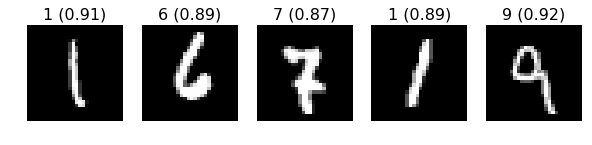

In [89]:
clean_x = X_train[20:25] # Take a sample
plots_with_preds(clean_x)

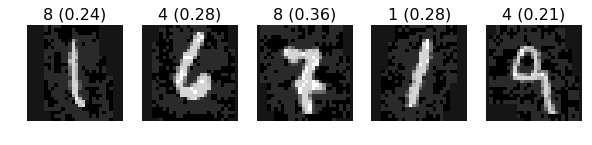

In [90]:
adv_x = fgsm.generate(x, eps=0.1)
np_adv_x = adv_x.eval(session=sess, feed_dict={x: clean_x})
plots_with_preds(np_adv_x)

## Repeat the process, using adversarial training

In [11]:
# Redefine TF model graph
model_2 = make_basic_cnn()
preds_2 = model_2(x)
fgsm2 = FastGradientMethod(model_2, sess=sess)
preds_2_adv = model_2(fgsm2.generate(x, eps=0.3))

def evaluate_2():
    # Accuracy of adversarially trained model on legitimate test inputs
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, preds_2, X_test, Y_test,
                          args=eval_params)
    print('Test accuracy on legitimate examples: %0.4f' % accuracy)
    report.adv_train_clean_eval = accuracy

    # Accuracy of the adversarially trained model on adversarial examples
    accuracy = model_eval(sess, x, y, preds_2_adv, X_test,
                          Y_test, args=eval_params)
    print('Test accuracy on adversarial examples: %0.4f' % accuracy)
    report.adv_train_adv_eval = accuracy

# Perform and evaluate adversarial training
model_train(sess, x, y, preds_2, X_train, Y_train,
            predictions_adv=preds_2_adv, evaluate=evaluate_2,
            args=train_params)

# Calculate training errors
if testing:
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, preds_2, X_train, Y_train,
                          args=eval_params)
    report.train_adv_train_clean_eval = accuracy
    accuracy = model_eval(sess, x, y, preds_2_adv, X_train,
                          Y_train, args=eval_params)
    report.train_adv_train_adv_eval = accuracy

return report

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


[INFO 2017-08-18 18:46:29,757 cleverhans] Epoch 0 took 5.364181995391846 seconds


Test accuracy on legitimate examples: 0.9888


[INFO 2017-08-18 18:46:35,291 cleverhans] Epoch 1 took 5.226948022842407 seconds


Test accuracy on legitimate examples: 0.9911


[INFO 2017-08-18 18:46:40,867 cleverhans] Epoch 2 took 5.26372766494751 seconds


Test accuracy on legitimate examples: 0.9919


[INFO 2017-08-18 18:46:46,484 cleverhans] Epoch 3 took 5.297043561935425 seconds


Test accuracy on legitimate examples: 0.9923


[INFO 2017-08-18 18:46:52,065 cleverhans] Epoch 4 took 5.258272886276245 seconds


Test accuracy on legitimate examples: 0.9921


[INFO 2017-08-18 18:46:57,622 cleverhans] Epoch 5 took 5.243191719055176 seconds
[INFO 2017-08-18 18:46:57,937 cleverhans] Completed model training.


Test accuracy on legitimate examples: 0.9921
Test accuracy on adversarial examples: 0.0315

Repeating the process, using adversarial training


[INFO 2017-08-18 18:47:12,434 cleverhans] Epoch 0 took 12.841004610061646 seconds


Test accuracy on legitimate examples: 0.9843
Test accuracy on adversarial examples: 0.8338


[INFO 2017-08-18 18:47:26,623 cleverhans] Epoch 1 took 12.865450859069824 seconds


Test accuracy on legitimate examples: 0.9887
Test accuracy on adversarial examples: 0.9132


[INFO 2017-08-18 18:47:40,846 cleverhans] Epoch 2 took 12.928793907165527 seconds


Test accuracy on legitimate examples: 0.9907
Test accuracy on adversarial examples: 0.9528


[INFO 2017-08-18 18:47:55,091 cleverhans] Epoch 3 took 12.922166109085083 seconds


Test accuracy on legitimate examples: 0.9909
Test accuracy on adversarial examples: 0.9661


[INFO 2017-08-18 18:48:09,261 cleverhans] Epoch 4 took 12.88106918334961 seconds


Test accuracy on legitimate examples: 0.9912
Test accuracy on adversarial examples: 0.9745


[INFO 2017-08-18 18:48:23,448 cleverhans] Epoch 5 took 12.87917971611023 seconds


Test accuracy on legitimate examples: 0.9921


[INFO 2017-08-18 18:48:24,773 cleverhans] Completed model training.


Test accuracy on adversarial examples: 0.9779


SyntaxError: 'return' outside function (<ipython-input-11-30e3d9483b2c>, line 132)